In [ ]:
import numpy as np
import psycopg2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [8]:
# Connecting to the Database
print("Trying to connect to db")
conn = psycopg2.connect(
    database="piscineds",
    user="ggobert",
    password="mysecretpassword",
    host=0
)
print("Connection success!")

cur = conn.cursor()
cur.execute("""
    WITH purchases AS (
        SELECT 
            user_id,
            event_time,
            CAST(REPLACE(REPLACE(price::text, '$', ''), ',', '') AS FLOAT) AS price
        FROM 
            customers
        WHERE 
            event_type = 'purchase'
    ),

    last_date AS (
        SELECT 
            MAX(event_time) AS max_date
        FROM 
            purchases
    ),

    rfm_base AS (
        SELECT 
            p.user_id,
            MAX(p.event_time) AS last_purchase,
            COUNT(*) AS frequency,
            SUM(p.price) AS monetary
        FROM 
            purchases p
        GROUP BY 
            p.user_id
    )

    SELECT 
        EXTRACT(DAY FROM (l.max_date - r.last_purchase)) AS recency,
        r.frequency,
        r.monetary
    FROM 
        rfm_base r, last_date l;
""")
results = cur.fetchall()

cur.close()
conn.close()

Trying to connect to db
Connection success!


In [9]:
rfm = np.array(results)

scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm)

In [10]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_rfm)
    inertia.append(kmeans.inertia_)

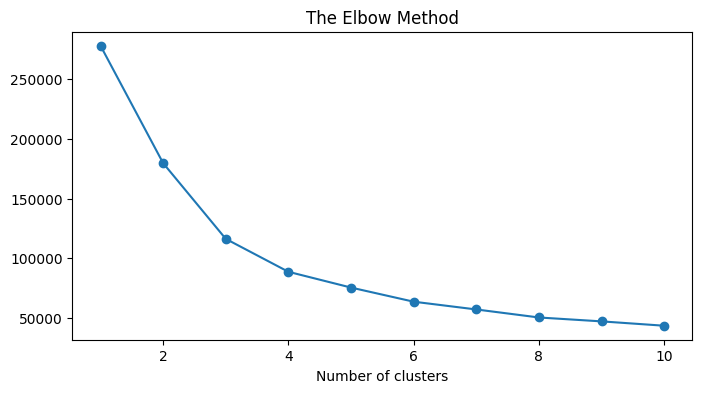

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.show()

7. Clustering

In [ ]:
# Application de KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_rfm)

KMeans(n_clusters=4, random_state=42)

Cluster 0: 26 utilisateurs
Cluster 1: 21 utilisateurs
Cluster 2: 28 utilisateurs
Cluster 3: 25 utilisateurs


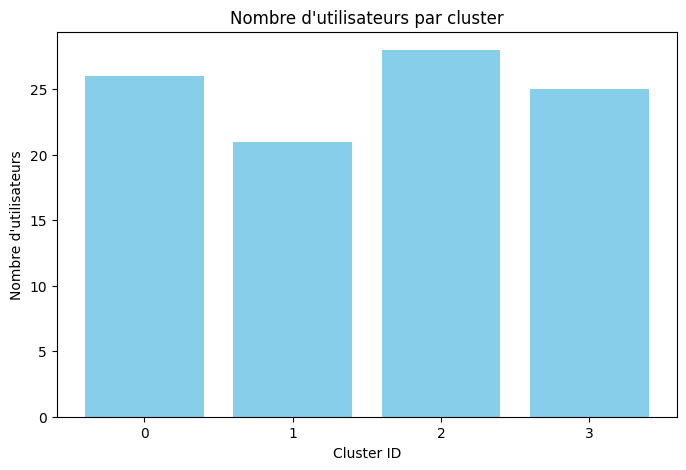

In [ ]:
labels_ = kmeans.labels_
unique, counts = np.unique(labels_, return_counts=True)

for label, count in zip(unique, counts):
    print(f"Cluster {label}: {count} utilisateurs")

plt.figure(figsize=(8, 5))
plt.bar(unique, counts, color='skyblue')
plt.xticks(unique)
plt.xlabel("Cluster ID")
plt.ylabel("Nombre d'utilisateurs")
plt.title("Nombre d'utilisateurs par cluster")
plt.show()


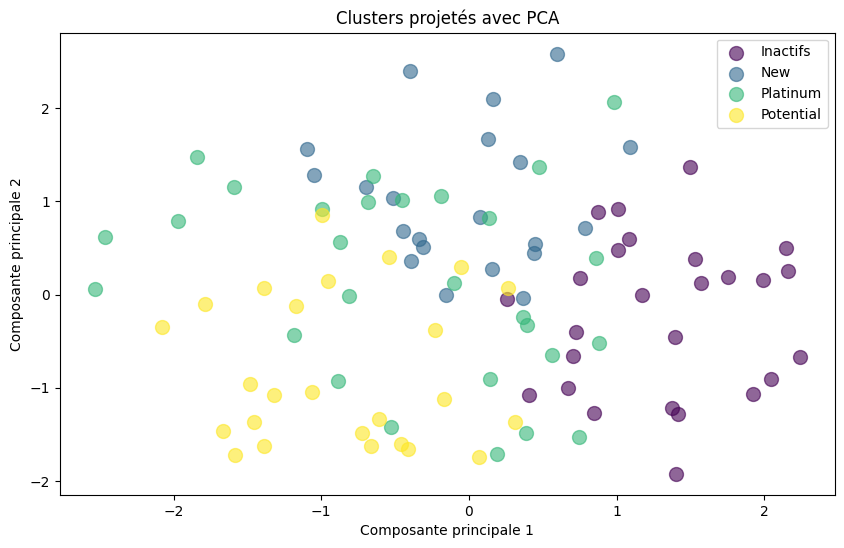

In [33]:
from sklearn.decomposition import PCA

# Réduction à 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_rfm)

# Refaire un scatter plot avec les nouvelles dimensions
plt.figure(figsize=(10, 6))
for cluster_id, name in cluster_names.items():
    cluster_data = reduced_data[labels_ == cluster_id]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=100, color=colors[name], label=name, alpha=0.6)

plt.title("Clusters projetés avec PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.show()


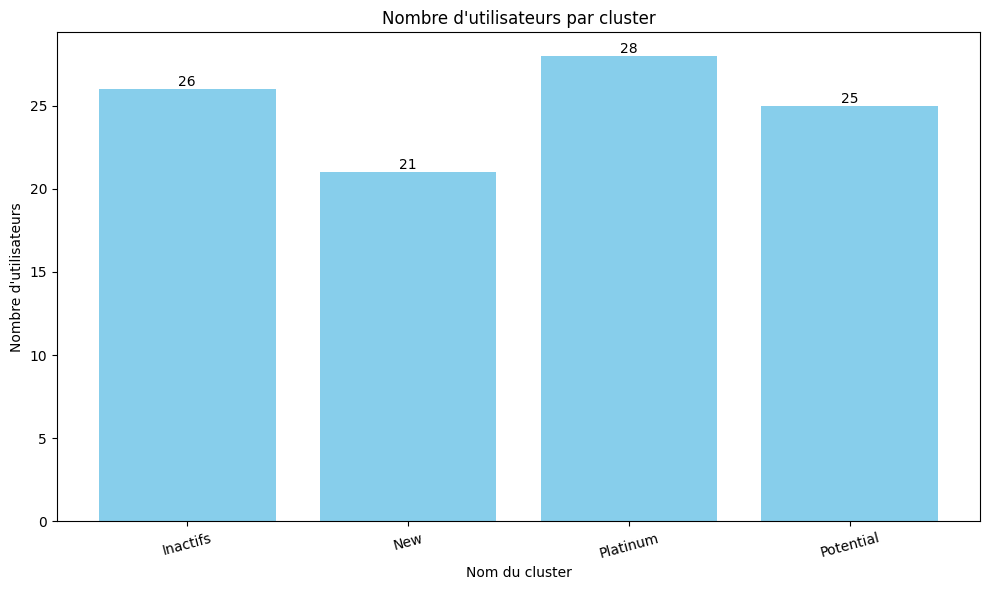

In [36]:
# Comptage des éléments dans chaque cluster
unique_labels, counts = np.unique(labels_, return_counts=True)

# Mapping des noms de cluster
cluster_names_ordered = [cluster_names[i] for i in unique_labels]

# Création du graphique à barres
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_names_ordered, counts, color='skyblue')

# Ajout des étiquettes sur chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.title("Nombre d'utilisateurs par cluster")
plt.ylabel("Nombre d'utilisateurs")
plt.xlabel("Nom du cluster")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
